In [1]:
import cv2, glob, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/urllib/request.py", line 1346, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/http/client.py", line 1285, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/http/client.py", line 1331, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/http/client.py", line 1280, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/http/client.py", line 1040, in _send_output
    self.send(msg)
  File "/home/macy/miniconda3/envs/mage/lib/python3.9/http/client.py", line 980, in send
    self.connect()
  File "/home/macy/miniconda3/envs/ma

In [2]:
train_img = glob.glob('./train/*_input.jpg')
train_mask = glob.glob('./train/*_target.jpg')
train_img.sort(); train_mask.sort()

In [3]:
len(train_img)

5000

In [4]:
cv2.imread(train_mask[0]).shape

(512, 512, 3)

In [5]:
cv2.imread(train_img[0]).shape

(512, 512, 3)

In [6]:
class FoodDataset(D.Dataset):
    def __init__(self, images, masks, transform=None):
        """
        初始化数据集。

        :param images: 图像文件路径列表
        :param masks: 掩码文件路径列表
        :param transform: 图像和掩码的变换操作（数据增强）
        """
        self.images = images
        self.masks = masks
        self.transform = transform
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101]),
        ])
        
    def __getitem__(self, index):
        """
        获取指定索引的数据。

        :param index: 索引值
        :return: 图像张量和归一化的掩码张量
        """
        image = cv2.imread(self.images[index])
        mask = cv2.imread(self.masks[index])  # 读取为三通道图像

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = self.as_tensor(image)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1) / 255.0  # 转换为张量，并保持三通道
        
        return image, mask

    def __len__(self):
        """
        获取数据集的长度。

        :return: 数据集大小
        """
        return len(self.images)

# 定义数据增强和预处理
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.RandomGamma(),
        A.ColorJitter(brightness=0.07, contrast=0.07, saturation=0.1, hue=0.1, p=0.3),
    ], p=0.3),
    A.ShiftScaleRotate(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
])

# 创建数据集
train_ds = FoodDataset(train_img[:-200], train_mask[:-200], transform=train_transform)
val_ds = FoodDataset(train_img[-200:], train_mask[-200:], transform=val_transform)

/home/macy/miniconda3/envs/mage/lib/python3.9/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [7]:
train_ds[0][1].shape

torch.Size([3, 512, 512])

In [8]:
train_loader = D.DataLoader( train_ds, batch_size=4, shuffle=True, num_workers=3)
val_loader = D.DataLoader( val_ds, batch_size=4, shuffle=False, num_workers=3)

## Unet

In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3
)

# model = smp.DeepLabV3(
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=103,                      # model output channels (number of classes in your dataset)
# )

100%|██████████| 1200/1200 [07:18<00:00,  2.74it/s]


Epoch 1/50
Train Loss: 0.0651, Validation Loss: 0.0468
Time: 7.40 minutes



100%|██████████| 1200/1200 [07:13<00:00,  2.77it/s]


Epoch 2/50
Train Loss: 0.0475, Validation Loss: 0.0654
Time: 7.31 minutes



100%|██████████| 1200/1200 [07:13<00:00,  2.77it/s]


Epoch 3/50
Train Loss: 0.0440, Validation Loss: 0.0696
Time: 7.31 minutes



100%|██████████| 1200/1200 [07:12<00:00,  2.77it/s]


Epoch 4/50
Train Loss: 0.0398, Validation Loss: 0.0342
Time: 7.30 minutes



100%|██████████| 1200/1200 [07:13<00:00,  2.77it/s]


Epoch 5/50
Train Loss: 0.0373, Validation Loss: 0.0297
Time: 7.32 minutes



100%|██████████| 1200/1200 [07:06<00:00,  2.82it/s]


Epoch 6/50
Train Loss: 0.0352, Validation Loss: 0.0283
Time: 7.19 minutes



100%|██████████| 1200/1200 [07:08<00:00,  2.80it/s]


Epoch 7/50
Train Loss: 0.0339, Validation Loss: 0.0285
Time: 7.22 minutes



100%|██████████| 1200/1200 [07:04<00:00,  2.83it/s]


Epoch 8/50
Train Loss: 0.0328, Validation Loss: 0.0283
Time: 7.16 minutes



100%|██████████| 1200/1200 [06:59<00:00,  2.86it/s]


Epoch 9/50
Train Loss: 0.0322, Validation Loss: 0.0282
Time: 7.07 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 10/50
Train Loss: 0.0308, Validation Loss: 0.0271
Time: 7.11 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.85it/s]


Epoch 11/50
Train Loss: 0.0297, Validation Loss: 0.0257
Time: 7.10 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 12/50
Train Loss: 0.0290, Validation Loss: 0.0259
Time: 7.13 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.86it/s]


Epoch 13/50
Train Loss: 0.0292, Validation Loss: 0.0350
Time: 7.09 minutes



100%|██████████| 1200/1200 [07:04<00:00,  2.83it/s]


Epoch 14/50
Train Loss: 0.0280, Validation Loss: 0.0241
Time: 7.15 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 15/50
Train Loss: 0.0276, Validation Loss: 0.0244
Time: 7.12 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 16/50
Train Loss: 0.0272, Validation Loss: 0.0236
Time: 7.13 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.85it/s]


Epoch 17/50
Train Loss: 0.0268, Validation Loss: 0.0299
Time: 7.10 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.85it/s]


Epoch 18/50
Train Loss: 0.0266, Validation Loss: 0.0242
Time: 7.09 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 19/50
Train Loss: 0.0259, Validation Loss: 0.0271
Time: 7.10 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 20/50
Train Loss: 0.0253, Validation Loss: 0.0253
Time: 7.15 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.84it/s]


Epoch 21/50
Train Loss: 0.0249, Validation Loss: 0.0254
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.84it/s]


Epoch 22/50
Train Loss: 0.0247, Validation Loss: 0.0229
Time: 7.11 minutes



100%|██████████| 1200/1200 [10:58<00:00,  1.82it/s]


Epoch 23/50
Train Loss: 0.0241, Validation Loss: 0.0225
Time: 11.11 minutes



100%|██████████| 1200/1200 [13:12<00:00,  1.51it/s]


Epoch 24/50
Train Loss: 0.0237, Validation Loss: 0.0214
Time: 13.35 minutes



100%|██████████| 1200/1200 [13:11<00:00,  1.52it/s]


Epoch 25/50
Train Loss: 0.0235, Validation Loss: 0.0211
Time: 13.34 minutes



100%|██████████| 1200/1200 [07:39<00:00,  2.61it/s]


Epoch 26/50
Train Loss: 0.0230, Validation Loss: 0.0222
Time: 7.74 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 27/50
Train Loss: 0.0226, Validation Loss: 0.0208
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 28/50
Train Loss: 0.0225, Validation Loss: 0.0211
Time: 7.15 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 29/50
Train Loss: 0.0219, Validation Loss: 0.0206
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 30/50
Train Loss: 0.0217, Validation Loss: 0.0207
Time: 7.15 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 31/50
Train Loss: 0.0215, Validation Loss: 0.0204
Time: 7.12 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 32/50
Train Loss: 0.0211, Validation Loss: 0.0205
Time: 7.12 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 33/50
Train Loss: 0.0210, Validation Loss: 0.0203
Time: 7.11 minutes



100%|██████████| 1200/1200 [07:04<00:00,  2.83it/s]


Epoch 34/50
Train Loss: 0.0206, Validation Loss: 0.0202
Time: 7.16 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 35/50
Train Loss: 0.0205, Validation Loss: 0.0198
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.85it/s]


Epoch 36/50
Train Loss: 0.0202, Validation Loss: 0.0204
Time: 7.10 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 37/50
Train Loss: 0.0200, Validation Loss: 0.0198
Time: 7.10 minutes



100%|██████████| 1200/1200 [06:59<00:00,  2.86it/s]


Epoch 38/50
Train Loss: 0.0198, Validation Loss: 0.0202
Time: 7.08 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 39/50
Train Loss: 0.0196, Validation Loss: 0.0200
Time: 7.11 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 40/50
Train Loss: 0.0194, Validation Loss: 0.0195
Time: 7.11 minutes



100%|██████████| 1200/1200 [06:59<00:00,  2.86it/s]


Epoch 41/50
Train Loss: 0.0193, Validation Loss: 0.0195
Time: 7.08 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 42/50
Train Loss: 0.0190, Validation Loss: 0.0194
Time: 7.11 minutes



100%|██████████| 1200/1200 [07:00<00:00,  2.85it/s]


Epoch 43/50
Train Loss: 0.0190, Validation Loss: 0.0192
Time: 7.10 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 44/50
Train Loss: 0.0188, Validation Loss: 0.0193
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:05<00:00,  2.82it/s]


Epoch 45/50
Train Loss: 0.0189, Validation Loss: 0.0193
Time: 7.17 minutes



100%|██████████| 1200/1200 [07:04<00:00,  2.83it/s]


Epoch 46/50
Train Loss: 0.0187, Validation Loss: 0.0193
Time: 7.16 minutes



100%|██████████| 1200/1200 [07:01<00:00,  2.85it/s]


Epoch 47/50
Train Loss: 0.0187, Validation Loss: 0.0194
Time: 7.11 minutes



100%|██████████| 1200/1200 [07:03<00:00,  2.83it/s]


Epoch 48/50
Train Loss: 0.0185, Validation Loss: 0.0193
Time: 7.14 minutes



100%|██████████| 1200/1200 [07:04<00:00,  2.83it/s]


Epoch 49/50
Train Loss: 0.0186, Validation Loss: 0.0192
Time: 7.16 minutes



100%|██████████| 1200/1200 [07:02<00:00,  2.84it/s]


Epoch 50/50
Train Loss: 0.0186, Validation Loss: 0.0192
Time: 7.13 minutes



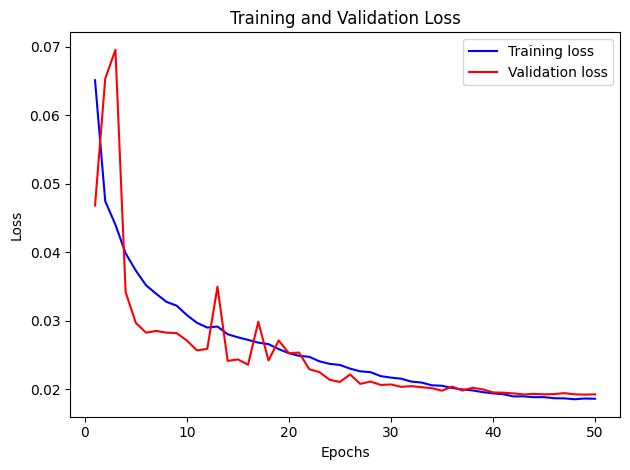

In [10]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to('cuda'), target.to('cuda').float()
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
                
    avg_loss = np.array(losses).mean()
    return avg_loss


EPOCHES = 50
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHES)
bce_fn = nn.MSELoss()


train_losses = []
val_losses = []

for epoch in range(1, EPOCHES + 1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm(train_loader):
        image, target = image.to('cuda'), target.to('cuda').float()
        optimizer.zero_grad()
        output = model(image)
        loss = bce_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    avg_train_loss = np.mean(losses)
    avg_loss = validation(model, val_loader, bce_fn)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_loss)
    
    # Update learning rate
    scheduler.step()
    
    print(f"Epoch {epoch}/{EPOCHES}")
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_loss:.4f}")
    print(f"Time: {(time.time() - start_time) / 60:.2f} minutes\n")

epochs = range(1, EPOCHES + 1)
plt.figure()
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
output.shape, target.shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 3, 512, 512]))

In [12]:
model.eval()
for image, target in val_loader:
    image, target = image.to('cuda'), target.to('cuda').float()
    output = model(image)
    break

In [13]:
output = (output.data.cpu().numpy() * 255).astype(np.uint8)
output = output[3]
output = np.transpose(output, (1,2, 0))

target = (target.data.cpu().numpy() * 255).astype(np.uint8)
target = target[3]
target = np.transpose(target, (1,2, 0))

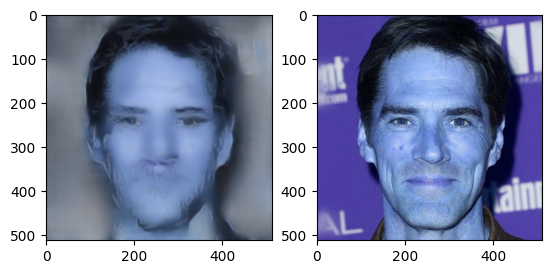

In [14]:
plt.subplot(121)
plt.imshow(output)

plt.subplot(122)
plt.imshow(target)

In [15]:
trfm = A.Compose([
    A.Resize(512,512),
])
test_img = glob.glob('./test/*_input.jpg')
test_img.sort()
test_ds = FoodDataset(test_img, test_img, transform=trfm)
test_loader = D.DataLoader( test_ds, batch_size=4, shuffle=False, num_workers=3)

In [16]:
!mkdir submit

mkdir: cannot create directory ‘submit’: File exists


In [17]:
model.eval()
idx = 0
with torch.no_grad():
    for image, target in test_loader:
        image, target = image.to('cuda'), target.to('cuda').float()
        outputs = model(image)
        outputs = (outputs.data.cpu().numpy() * 255).astype(np.uint8)
        for output in outputs:
            output = np.transpose(output, (1,2, 0))
            cv2.imwrite('submit/' + test_img[idx].split('/')[-1].replace('input', 'target'), output)
            idx += 1

In [18]:
!ls -l submit | wc -l
!ls -l test | wc -l

1501
1501


In [19]:
!zip -r submit-eff-50.zip submit

  adding: submit/ (stored 0%)
  adding: submit/8a0dd6ac-33b8-4e93-8399-8e380e9db5dd_target.jpg (deflated 1%)
  adding: submit/5110609d-0a82-478b-b88b-20994ffbe497_target.jpg (deflated 1%)
  adding: submit/d48a53ad-5398-4b4b-bd48-b37125eb2eca_target.jpg (deflated 1%)
  adding: submit/28d2edb3-d329-4953-b2d6-367cd35ed73b_target.jpg (deflated 0%)
  adding: submit/0b1ddee9-b85c-451b-bfab-07f82265d286_target.jpg (deflated 0%)
  adding: submit/99cf8890-b01a-41c7-85bd-3f858151e516_target.jpg (deflated 0%)
  adding: submit/e3276417-ad4f-4ec0-ba3a-0caa20ef7ccb_target.jpg (deflated 0%)
  adding: submit/8f4a9823-d987-4e2e-a14f-b4134026d882_target.jpg (deflated 0%)
  adding: submit/980c5c25-fae1-4d64-8e43-d6874bd6e01d_target.jpg (deflated 0%)
  adding: submit/08712ab1-adc5-46ce-a8ce-6468331309e4_target.jpg (deflated 0%)
  adding: submit/0b156ff7-fc96-41f0-a65c-3cfadb3147b5_target.jpg (deflated 0%)
  adding: submit/d649473e-3f23-4368-ba37-dc90937c3653_target.jpg (deflated 0%)
  adding: submit/a1f1b